In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Análisis exploratorio de Ventas (ventas.txt)
En este archivo, podemos encontrar las ventas diarias del producto en cuestión, discriminadas por unidades.
El objetivo de notebook será generar un dataset preprocesado que acumule las ventas para los distintos puntos de venta.

Las columnas son: 
- fecha: Fecha de venta.
- id_pos: Identificador único de Punto de Venta.
- cantidad_envios: Cantidad de productos vendidos.
- canal: Es la clase de tienda en la que se realizó la venta.

Realizamos la importación del archivo de ventas, y una descripción del dataset: 
- utilizamos la función **describe** que nos ofrece estadísticas sobre el dataset
- utilizamos la función **info** que visualiza el tipo de datos de las columnas
- utilizamos la función **sample** que nos retorna un ejemplo de datos

In [2]:
df_ventas = (
    pd.read_csv(
        '../data/raw/ventas.txt', 
        delimiter = "|", 
        infer_datetime_format=True, 
        parse_dates=[0]
    )
)

df_ventas.sample(5)

,fecha,id_pos,unidades,canal
204576,2013-12-20,4656,1,ALMACEN
50043,2012-12-12,3537,1,ALMACEN
236765,2013-12-24,15539,3,ALMACEN
171847,2013-12-15,12268,3,ALMACEN
172346,2013-12-15,5487,1,ALMACEN


Realizamos un análisis descriptivo de las ventas

In [3]:
df_ventas.describe(include='all')

,fecha,id_pos,unidades,canal
count,266436,266436.000000,266436.000000,266436
unique,276,NaN,NaN,4
top,2013-12-24 00:00:00,NaN,NaN,ALMACEN
freq,9726,NaN,NaN,265207
first,2012-10-01 00:00:00,NaN,NaN,NaN
last,2014-11-30 00:00:00,NaN,NaN,NaN
mean,NaN,7973.083667,2.378481,NaN
std,NaN,4707.704857,2.391836,NaN
min,NaN,3142.000000,-29.000000,NaN
25%,NaN,4964.000000,1.000000,NaN


In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266436 entries, 0 to 266435
Data columns (total 4 columns):
fecha       266436 non-null datetime64[ns]
id_pos      266436 non-null int64
unidades    266436 non-null int64
canal       266436 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.1+ MB


El dataset no contiene valores nulos en ninguna fila:

In [5]:
df_ventas.isna().any()

fecha       False
id_pos      False
unidades    False
canal       False
dtype: bool

Con esta descripción obtenemos las siguientes conclusiones:
 - la fecha inicial es 01/10/2012 y el fin es 30/11/2014
 - tenemos 266436 muestras
 - tenemos 4 tipos de **canales**
 - en unidades hay valores negativos (posibles errores)
 - no existen valores faltantes en las columnas que debamos imputar

### Visualizando/explorando nuestros datos (Análisis Descriptivo)
Graficamos un diagrama de lineas y otro scatter con las ventas por fecha, agrupado por mes. Se puede observar un pico en las ventas en el mes de diciembre, naturalmente el producto tenía su pico en esos meses según la descripción del problema.

Verificamos cuantas muestras totales tenemos por mes: 

Con la técnica de "resampling", agrupamos los datos por mes, sumarizamos las unidades y contabilizamos la cantidad de ventas. Realizamos un gráfico por cada una de ellas.

Primero el gráfico por cantidad de ventas mensuales que posee el dataset:

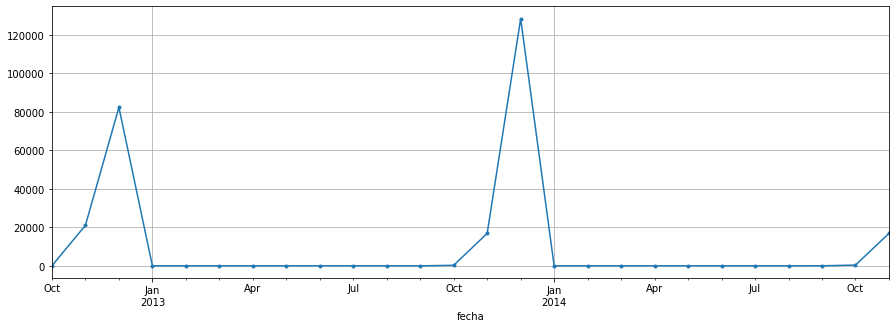

In [6]:
ax = ( 
    df_ventas
    .set_index("fecha")
    .resample("M")
    .size()
    .plot.line(figsize=(15,5), marker='.')
)
plt.grid(True)

Luego sumarizamos las unidades que tenemos por mes en todos los puntos de venta.

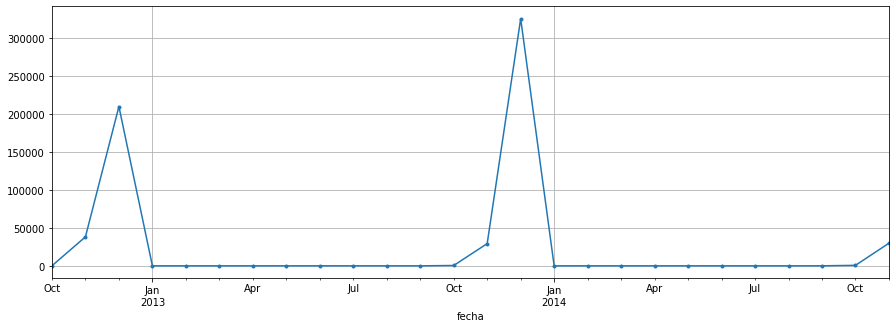

In [7]:
ax = ( 
    df_ventas
    .set_index("fecha")
    .resample("M")
    .unidades.sum()
    .plot.line(figsize=(15,5), marker='.')
)
plt.grid(True)

Realizamos el mismo gráfico, pero con los datos de las ventas diarias. Esto nos provee una vista de como nuestros datos se esparcen con respecto a las fechas. 

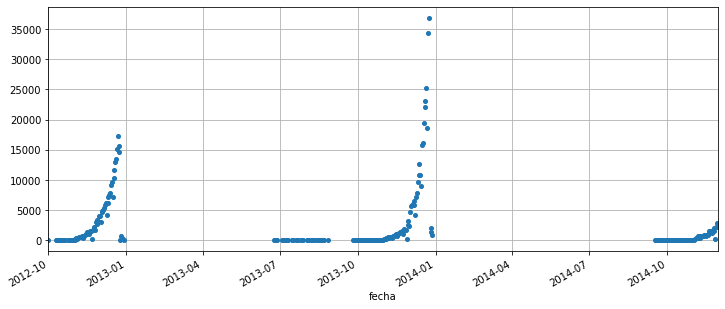

In [8]:
# Realizamos el mismo gráfico, pero con los puntos por día
ax = ( 
    df_ventas.set_index("fecha")
    .groupby('fecha').unidades.sum()
    .plot.line(figsize=(12,5), marker='.', grid=True, style="o", ms="8")
)

Visualizamos la cantidad de unidades por **día del año** que contiene nuestro dataset. 
Las fechas están codificadas como el día del año. Esto nos permite en el mismo gráfico, marcar las 3 lineas de ventas. El día del año corresponde a un número entre 1 y 365 ( o 366 si es un año bisiesto )

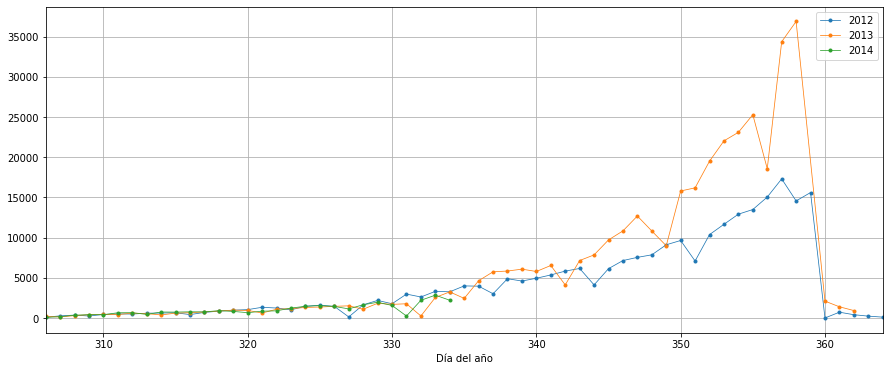

In [9]:
_, ax = plt.subplots(1,1, sharex=True, sharey=True)
for i in ["2012", "2013", "2014"]:
    data = df_ventas.set_index("fecha").loc[i]
    data.index = data.index.dayofyear
    data = data.loc[data.index > 305]
    data = data.groupby('fecha').unidades.sum()
    data.plot.line(figsize=(15,6), marker='.', ax=ax, linewidth=0.75)
    ax.grid(True)
    ax.set_xlabel("Día del año")
ax.legend(["2012", "2013", "2014"])
plt.savefig('../reports/figures/01-line-ventas_anuales.svg')

____
### Preprocesamiento columnas
En los siguientes apartados se revisarán los valores de las columnas del dataset para comprobar valores faltantes, errores, balanceo de datos, etc.
#### Analisis de id_pos


In [10]:
"Existen {} puntos de ventas en este archivo".format(len(df_ventas.id_pos.unique()))

'Existen 12302 puntos de ventas en este archivo'

Tendríamos que verificar si son todos las ventas correctas, o existen ventas que no deberían estar. Para ello verificamos en el archivo ejemploRespuesta.csv; revisamos si todas nuestras ventas tienen asociado un id_pos correcto: 

In [11]:
# recuperamos los id_pos del archivo de respuesta
df_ej_resp = pd.read_csv('../data/raw/ejemploRespuesta.csv', names=["id_pos", "unidades"])

#Buscamos los id_pos que se encuentren solamente en uno de los dos archivos
outer = (
    df_ej_resp
    .merge(pd.DataFrame(df_ventas.id_pos.unique(), columns=["id_pos"]), on=["id_pos"], indicator=True, how='outer')
    [lambda df: df._merge != 'both']
)[["id_pos", "_merge"]]


In [12]:
outer.melt(value_vars="_merge").value.value_counts()

left_only     1044
right_only     449
Name: value, dtype: int64

*Nota: left corresponde a lo id_pos que solo se encuentran en el archivo de respuesta ejemplo, y right corresponden a los que solo se encuentran en el archivo de ventas*

In [13]:
df_ventas[lambda df: ~df.id_pos.isin(df_ej_resp.id_pos)].count(0)

fecha       9523
id_pos      9523
unidades    9523
canal       9523
dtype: int64

*cantidad de ventas en las que no es un id_pos posible*

Como podemos observar existen 9523 ventas que no corresponden a id_pos posibles de respuesta (los cuales son 449 id erroneos), y también existen 1044 puntos de venta que no tienen ninguna venta del producto estrella. 

El análisis con el archivo pos.csv se realiza en la siguiente notebook, hay que tener en cuenta que pos.csv no es un archivo formateado y pueden haber datos sucios; como estamos realizando una limpieza por archivo es preferible retrasar un poco el mencionado análisis.

Verificamos si alguno de los puntos de ventas que no poseen ventas, se les ha enviado alguna cantidad del producto: 

In [14]:
df_envios = pd.read_csv('../data/raw/envios.txt', delimiter="|")

(
    df_envios
    .merge(outer[lambda df: df._merge=='left_only'][["id_pos"]], on="id_pos")
    .groupby('id_pos')
    .agg({"cantidad_envios":"sum", "unidades_despachadas":"sum"})
).sample(10)

,cantidad_envios,unidades_despachadas
id_pos,,
18298,1,12
8486,2,276
17608,1,12
42327,1,24
16192,1,12
32889,1,180
18475,1,12
15494,2,24
18491,1,24


Verificamos 28020 unidades del producto perdidas en los puntos de ventas que no hay realizado ninguna.

In [15]:
(
    df_envios
    .merge(outer[lambda df: df._merge=='left_only'][["id_pos"]], on="id_pos")
    .agg({"cantidad_envios":"sum", "unidades_despachadas":"sum"})
)

cantidad_envios          1058
unidades_despachadas    28020
dtype: int64

Como resolución de este apartado, descartamos las ventas que no corresponden a ningún punto de venta en el archivo de respuesta.

In [16]:
df_ventas[lambda df: df.id_pos.isin(df_ej_resp.id_pos)].to_parquet('../data/interim/01-ventas_pos_erroneos.parquet')
df_ventas = df_ventas[lambda df: df.id_pos.isin(df_ej_resp.id_pos)]
df_ventas.id_pos.count(), 266436 , "se redujo en {}".format(266436-df_ventas.id_pos.count())

(256913, 266436, 'se redujo en 9523')

#### Análisis **canales**
Como podemos observar en la tabla anterior tenemos 4 tipos de canales, los cuales son: MAXIKIOSKO, ALMACEN, SUPERMERCADOS Y PARTICULARES

In [17]:
list(df_ventas.canal.unique())

['MAXIKIOSCO', 'ALMACEN', 'SUPERMERCADOS', 'PARTICULARES']

In [18]:
df_ventas.groupby('id_pos').apply(lambda df: len(list(df.canal.unique())))[lambda df: df > 1].count()

79

Existen 79 Puntos de venta que tienen más de 1 canal de venta.

Podríamos ver la frecuencia de cada uno, y cuantos valores hay faltantes:

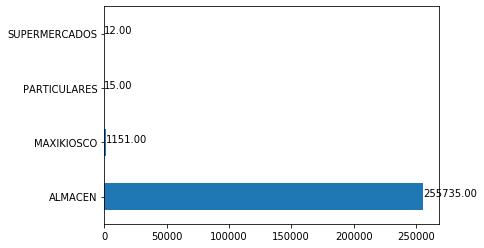

In [19]:
# imprimimos un gráfico de barras
ax = df_ventas.canal.fillna("FALTANTE").value_counts().plot.barh()
#imprimimos los labels númericos
[ax.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(df_ventas.canal.value_counts())];
plt.savefig('../reports/figures/01-barplot-canales.png')

Como se puede observar, la mayoría de nuestras muestras son del tipo "ALMACEN" (tenemos una alta cardinalidad en el atributo canal para la categoría almacen), y no posee valores faltantes. Intentamos completar los valores faltantes con el operador "fillna" pero no completó ningún elemento.  Podríamos agrupar todas las demás categorías en una sola con el valor "OTROS", aunque no sería de mucho interés lo hacemos solo para obtener algo un poco más ordenado.

[Text(255735, 0, '255735.00'), Text(1178, 1, '1178.00')]

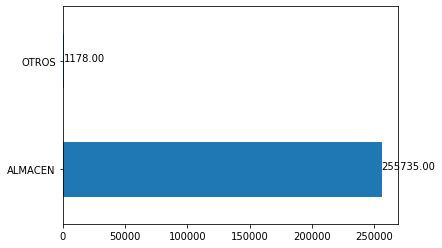

In [20]:
from src.features.build_features import group_canal

group_canal(df_ventas)
ax = df_ventas.canal.fillna("FALTANTE").value_counts().plot.barh()
[ax.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(df_ventas.canal.value_counts())]

La cantidad de ejemplos de "OTROS" representa el 0.5%, por ende la mayoría de las muestras caeran en "ALMACEN". 

Decidimos remover la columna canal por el momento, ya que la misma no es representativa de los datos.

In [21]:
df_ventas = df_ventas.drop("canal", axis=1, errors='ignore')

____
#### Análisis de **unidades**

Verificamos los valores de **unidades** para descubrir faltantes o errores, realizamos con un diagrama de cajas para verificar si existen valores fuera de rango. 

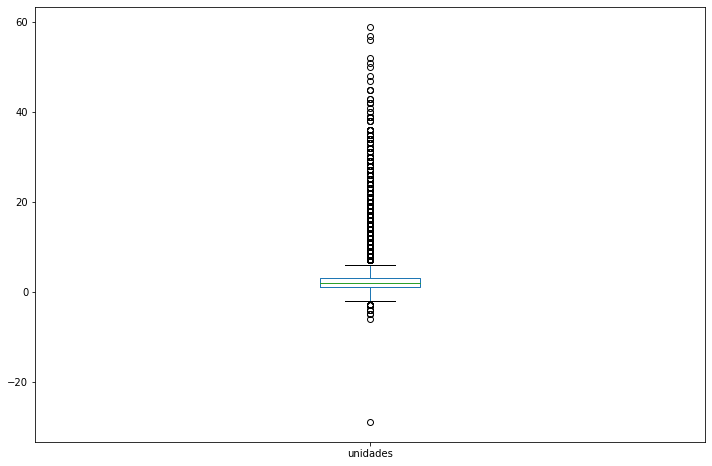

In [22]:
ax = df_ventas.unidades.plot.box(figsize=(12,8))
plt.savefig("../reports/figures/01-boxplot-unidades.png")

En el gráfico anterior, podemos ver varios valores atípicos (outliers). No deberíamos quitar los valores atípicos positivos ya que puede ser que dependiendo donde se encuentre el punto de venta, podrían ocurrir dichas ventas con valores de unidades altos, por ejemplo en una zona céntrica.

Tendríamos que verificar que son los valores negativos de unidades. Observamos 109 muestras que poseen valores negativos, se visualizan los primeros 10 ordenados por unidades

In [23]:
# vamos a guardar las ventas que tienen valores de unidades negativas
df_ventas_negativas = (
    df_ventas[lambda df: df.unidades <= 0]
    .sort_values(['unidades',"id_pos"], ascending=True)
)

In [24]:
print("(filas, columnas): ",df_ventas_negativas.shape)
df_ventas_negativas.head(10)
df_ventas.count()

(filas, columnas):  (109, 3)


fecha       256913
id_pos      256913
unidades    256913
dtype: int64

¿Estas unidades corresponderán a devoluciones?, ¿serán errores de tipeo?
Según cuál caso ocurriese, se podría recurrir a alguna de estas soluciones: 

- si fueran devoluciones 
    tendría que existir una compra en días anteriores de la misma cantidad
- si fueran errores de tipeo, 
    tendríamos que cambiar el signo de dichas muestras
- si fueran otro tipo de error,
    deberíamos descartar esa muestra 
   
Como en realidad lo que queremos predecir son las ventas, no nos interesa si existen devoluciones; en el supuesto caso que fueran errores de tipeo no tendríamos forma de comprobarlo. 
La opción de descartar dichos elementos de la muestra no es tan descabellada: tenemos 256913 de las cuales 109 son las que tienen valores negativos en unidades. Estas 109 muestras representan el 0.05% de las muestras.

Se agrega una notebook donde se intenta verificar cuál es la cantidad de de estos 109 elementos que podrían ser devoluciones correctas. [Analisis alternativo](./otros/analizando-devoluciones.ipynb)

Procedemos a eliminar las ventas donde unidades posee valores negativos:

In [25]:
df_ventas = df_ventas.drop(df_ventas.loc[lambda df: df.unidades <=0].index)
print(df_ventas.shape)

(256804, 3)


Volvemos a graficar el diagrama de caja para comprobar que dichos valores fueron removidos:

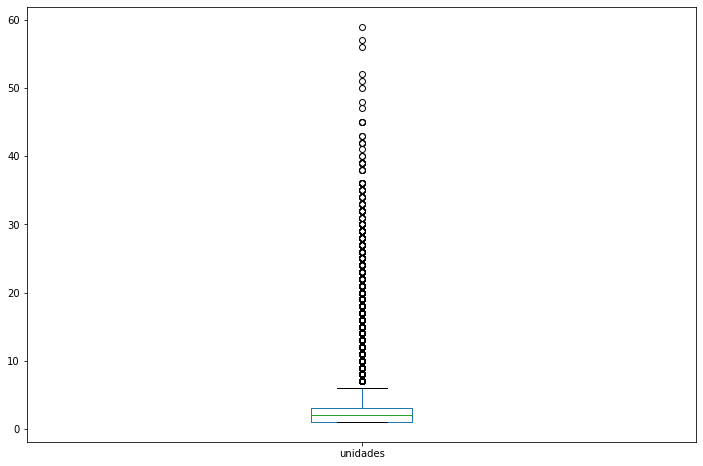

In [26]:
df_ventas.unidades.plot.box(figsize=(12,8))

Observamos que nuestras muestras se agrupan en su mayoría con valores pequeños, entre 1 y 10, por fechas de ventas. Es decir en la mayoría de los POS, por día, venden pocas unidades del producto.

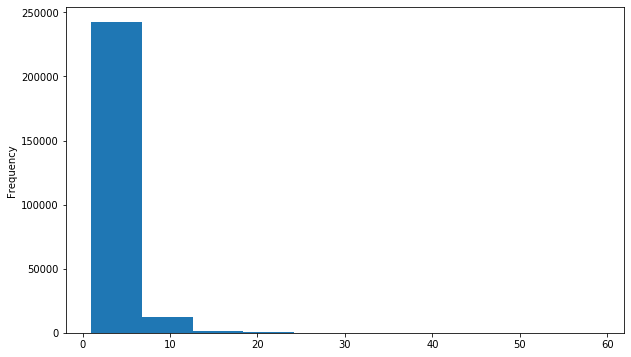

In [27]:
df_ventas.set_index('fecha').unidades.plot.hist(figsize=(10,6))

____

### Agregando Features
Podemos totabilizar las ventas por id_pos

In [28]:
# agrupamos por id_pos y calculamos métricas
grouped_by_ventas = (
    df_ventas.groupby("id_pos")
    .agg({"id_pos":["count"], "unidades":["sum", "mean", "std"]})
)

# cambiamos el nombre de las columnas
grouped_by_ventas.columns = [
    "cantidad_ventas", 
    "unidades_suma",
    "unidades_media", 
    "unidades_desviacion"
]

# ordenamos los valores por cantidad de ventas acumuladas y retornamos 15
grouped_by_ventas.sort_values("cantidad_ventas", ascending=False).head(5)

,cantidad_ventas,unidades_suma,unidades_media,unidades_desviacion
id_pos,,,,
4369,98,296,3.020408,2.580576
3683,95,304,3.200000,3.086001
4695,93,317,3.408602,3.710258
4761,91,472,5.186813,5.324810
4619,91,318,3.494505,3.484485


In [29]:
# Obtenemos las últimas 5
grouped_by_ventas.sort_values("cantidad_ventas", ascending=False).tail(5)

,cantidad_ventas,unidades_suma,unidades_media,unidades_desviacion
id_pos,,,,
17319,1,1,1.0,NaN
17318,1,2,2.0,NaN
17315,1,2,2.0,NaN
17313,1,8,8.0,NaN
10865,1,1,1.0,NaN


*Nota: la desviación da NaN, porque es la única muestra.*

Con un histograma podemos conocer la frecuencia de los valores de cantidad_ventas. Con ellos podemos observar que los valores entre 49.5 en adelante se encuentran en menor proporción. Los datos nos están diciendo que los puntos de ventas tienen **poca cantidad de ventas individualmente** en su mayoría.

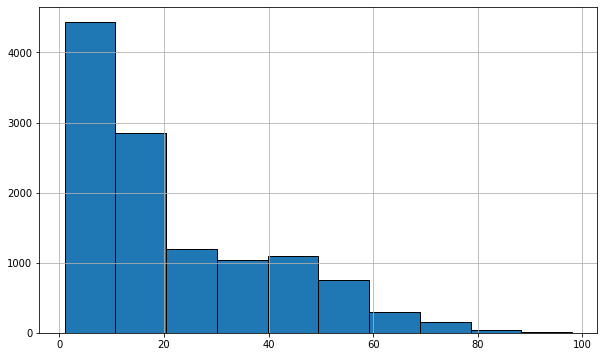

In [30]:
df_ventas_por_pos = grouped_by_ventas[["cantidad_ventas"]]
df_ventas_por_pos.columns = ["ventas"]
ax = df_ventas_por_pos.ventas.hist(bins=10, edgecolor="k",figsize=(10,6))
plt.savefig('../reports/figures/01-hist-cantidad_ventas.png')

Podríamos generar una nueva característica según la cantidad de ventas. Esto se agrega luego en el analisis de puntos de venta.

#### Fechas
Podríamos generar nuevas características derivadas del atributo fecha, las cuales pueden ser: 
- dayofyear: corresponde al día del año (1-365)
- weekofyear: corresponde a la semana del año (1-52)
- dayofweek: corresponde al día de la semana ( 0 [lunes] - 6 [domingo] )
- ...

En realidad, como las predicciones las tenemos que realizar por mes, hay ciertos atributos de las fechas que no son de interés, quizás si quisieramos modelar las ventas diarias, si lo serían. 

Por ende, solo vamos a quedarnos con el mes y el año. Luego, agruparemos por id_pos, mes y año la cantidad de productos vendidos. Es decir por punto de ventas vamos a tener 3 años, lo que corresponde a 35 muestras por cada punto de venta.
Vamos a generar los datos que no existan (con valores de unidad 0) estos nos va a permitir tener la serie de tiempo completa desde el inicio (enero-2012) hasta el fin (noviembre-2014).


In [31]:
dateindex = pd.date_range('31/01/2012', periods=35, freq='M')

In [32]:
df_ventas = (
    df_ventas
    .set_index('fecha')
    [['id_pos', 'unidades']]
    .groupby('id_pos')
    .resample('M')
    .agg({"unidades":["sum", "count"]})
)

In [33]:
df_ventas.shape

(159573, 2)

In [34]:
df_ventas = (
    df_ventas
    .reindex(pd.MultiIndex.from_product([df_ventas.index.levels[0], dateindex]), fill_value=0)
).reset_index()

In [35]:
df_ventas.shape

(414855, 4)

In [36]:
df_ventas.columns = ["id_pos","fecha","unidades","cantidad_ventas"]

In [37]:
from src.features.build_features import add_date_features
add_date_features(df_ventas, "fecha").head()

,id_pos,unidades,cantidad_ventas,year,month
0,3142,0,0,2012,1
1,3142,0,0,2012,2
2,3142,0,0,2012,3
3,3142,0,0,2012,4
4,3142,0,0,2012,5


In [38]:
df_ventas.shape, df_ventas.id_pos.unique().shape

((414855, 7), (11853,))

Procedemos a guardar el archivo para su utilización

In [39]:
df_ventas.to_parquet('../data/interim/01-ventas.parquet')

## Conclusión del apartado

- Generamos atributos derivados de fechas
- Removimos las ventas que tenían unidades negativas
- Detectamos muchos valores outliers superiores, pero que los no quitamos dada la naturaleza del problema.
- Recordar que tenemos por cada punto de venta que almenos tiene una venta, el conjunto de los 35 meses correspondientes de 2012 a 2014. 
- Los puntos de venta que no tienen ventas, no se encuentran en el archivo intermedio.

Procedemos a guardar nuestro dataset modificado. Los archivos parquet es un formato de datos columnar, que se utiliza en el almacenamiento de grandes volúmenes. Podríamos guardar un csv, pero el archivo parquet ocupa menos espacio en disco.

Siguiente: [02-analisis-exploratorio-pos](./02-analisis-exploratorio-pos.ipynb)

Siguientex2: [Tratamiento-Predicción-Time-Series](./Tratamiento_TS.ipynb)

_______

## ANEXO: Análisis Descriptivo
Como una manera de realizar una predicción de producción, se realiza la predicción de ventas en general para el mes de diciembre. Esta resolución podría ser tomada como una solución gerencial; en cambio, en una solución por POS, podría ser tomada como una predicción de distribución donde los interesados sean los POS. 

### ¿Cuál establecimiento vendió más productos en cantidad de unidades?
El establecimiento que más productos vendió fue el id_pos: 4761 con 472 unidades

In [40]:
grouped_by_ventas.loc[grouped_by_ventas.unidades_suma.idxmax()]

cantidad_ventas         91.000000
unidades_suma          472.000000
unidades_media           5.186813
unidades_desviacion      5.324810
Name: 4761, dtype: float64

### ¿Cuál establecimiento tiene la media mas alta de productos?
El establecimiento 6656 es el que tiene la más alta media de unidades vendidas con 12.2 unidades.

In [41]:
grouped_by_ventas.loc[grouped_by_ventas.unidades_media.idxmax()]

cantidad_ventas         10.000000
unidades_suma          122.000000
unidades_media          12.200000
unidades_desviacion      6.338594
Name: 6656, dtype: float64

### ¿Cuál día es el que más productos se vendió? (general)
Como podemos observar el pico de ventas del año 2013 se encuentra el día 24 de diciembre, con 36882 unidades de ventas. En el año 2012, el pico de ventas se encuentra el día 22 de diciembre con 17303 ventas. Esto se puede llegar a explicar por el día en el que cae 24 en el año 2012, 22 de diciembre es sábado y 24, lunes. 

Esta conclusión se obtiene de que, normalmente, la gente no suele hacer compras los domingos dado que los lugares de ventas se encuentran cerrados. No obstante, está conclusión puede quedar anulada si los negocios tienen horario "de fiestas". 


In [42]:
( 
    df_ventas.set_index("fecha")
    .groupby('fecha')
    .agg({"unidades":[sum]})
    .sort_values(("unidades","sum"),ascending=False)
    .head(10)
)

,unidades
,sum
fecha,
2013-12-31,313821
2012-12-31,202449
2012-11-30,36840
2014-11-30,28799
2013-11-30,28277
2014-10-31,650
2013-10-31,460
2012-10-31,92


### ¿Cuál es el día y establecimiento en el que se vendieron más productos?
Podemos observar que en el top 10, menos 1 producto, todos son de diciembre. La mayoría de los productos son de la semana de fiestas (última semana de diciembre) y hay un solo caso de principio de mes con 48 ventas. 
Esos casos quizás correspondan a un día en el cual se realizó alguna promoción o descuento, pero no nos encontramos con estos datos para verificar.

In [43]:
(
    df_ventas.set_index('fecha')
    .groupby(['id_pos','fecha'])
    .agg({"unidades":["sum"]}).sort_values(("unidades", "sum"), ascending=False)
    .head(10)
)

,,unidades
,,sum
id_pos,fecha,
6653,2013-12-31,252
4700,2013-12-31,226
7609,2013-12-31,214
8453,2013-12-31,202
8454,2013-12-31,201
7967,2013-12-31,198
5739,2013-12-31,197
15204,2013-12-31,195
